In [1]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
License(s): CC0-1.0
 99% 1.21G/1.22G [00:18<00:00, 96.9MB/s]
100% 1.22G/1.22G [00:18<00:00, 71.7MB/s]


In [2]:
!unzip -q /content/hard-hat-detection.zip

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 22.1 MB/s eta 0:00:00


In [4]:
import os
import random
import shutil
import cv2
import glob
import yaml
import matplotlib.pyplot as plt
import ultralytics
import numpy as np
import torch
import xml.etree.ElementTree as ET
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
random.seed(2024)

In [6]:
ultralytics.checks()

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.0/112.6 GB disk)


In [7]:
data_root = '/content/images'
project_name = 'safe_halmet'

In [8]:
file_root = f'/content/data'
train_file_root = f'/content/data/{project_name}'
train_root = f'/content/data/{project_name}/train'
val_root = f'/content/data/{project_name}/val'
test_root = f'/content/data/{project_name}/test'

In [9]:
for folder in [train_root, val_root, test_root] :

    if not os.path.exists(folder) :
        os.makedirs(folder)

    for cls in ['images', 'labels'] :
        cls_folder = f'{folder}/{cls}'

        if not os.path.exists(cls_folder) :
            os.makedirs(cls_folder)

In [10]:
# images, annotation 넣어주기

file_list = glob.glob(f'/content/images/*.png')

len(file_list)

5000

In [11]:
def xml_to_yolo_bbox(bbox, w, h) :
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

In [12]:
os.makedirs('/content/labels')

In [13]:
classes = []

for file in tqdm(file_list) :
    file_name = file.split('/')[-1].replace('png', 'xml')
    save_name = file_name.replace('xml', 'txt')
    file_path = f'/content/annotations/{file_name}'
    save_path = f'/content/labels/{save_name}'

    result = list()
    tree = ET.parse(file_path)
    root = tree.getroot()

    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    for obj in root.findall('object') :
        label = obj.find('name').text

        if label not in classes :
            classes.append(label)

        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')

    if result :

        with open(save_path, 'w', encoding = 'utf-8') as f:
            f.write('\n'.join(result))

100%|██████████| 5000/5000 [00:02<00:00, 1827.98it/s]


In [14]:
classes

['helmet', 'head', 'person']

In [15]:
cls_list = ['head', 'helmet', 'person']

In [16]:
random.seed(2024)

In [17]:
random.shuffle(file_list)
test_ratio = 0.1
num_file= len(file_list)

test_list = file_list[: int(num_file * test_ratio)]
val_list = file_list[int(num_file * test_ratio) : int(num_file * test_ratio) * 2]
train_list = file_list[int(num_file * test_ratio) * 2 :]

In [18]:
for i in test_list :
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'/content/labels/{label_name}'
    shutil.copyfile(label_path, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/images/{img_name}')

for i in val_list :
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'/content/labels/{label_name}'
    shutil.copyfile(label_path, f'{val_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{val_root}/images/{img_name}')

for i in train_list :
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'/content/labels/{label_name}'
    shutil.copyfile(label_path, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/images/{img_name}')

In [19]:
print(len(os.listdir(f'{train_root}/images/')))
print(len(os.listdir(f'{val_root}/images/')))
print(len(os.listdir(f'{test_root}/images/')))

4000
500
500


In [20]:
project_root= '/content/data'

In [21]:
data = dict()

data['train'] = train_root
data['val'] = val_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{project_root}/safety_helmet.yaml', 'w') as f :
    yaml.dump(data, f)

In [22]:
%cd '/content/data'

/content/data


In [23]:
model = YOLO('yolov8n.pt')

# amp = False : 연산성능을 최적화 하기 위해서 fp16(False), fp32(True) 중 선택

results = model.train(data = 'safety_helmet.yaml', epochs = 2, batch = 8, imgsz = 224, device = 0,
                       workers = 4, amp = False, patience = 30, name = 'safety_n')

100%|██████████| 6.25M/6.25M [00:00<00:00, 90.7MB/s]


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=safety_helmet.yaml, epochs=2, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 21.0MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/data/safe_halmet/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:04<00:00, 851.96it/s] 


train: New cache created: /content/data/safe_halmet/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/data/safe_halmet/val/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 711.89it/s]

val: New cache created: /content/data/safe_halmet/val/labels.cache


Plotting labels to runs/detect/safety_n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_n
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.382G      1.859      1.863      1.113         42        224: 100%|██████████| 500/500 [01:15<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


                   all        500       2407      0.858      0.405      0.465      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2     0.359G       1.65      1.207      1.044         32        224: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]

                   all        500       2407      0.854      0.417      0.487      0.264



2 epochs completed in 0.046 hours.
Optimizer stripped from runs/detect/safety_n/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/safety_n/weights/best.pt, 6.2MB

Validating runs/detect/safety_n/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


                   all        500       2407      0.853      0.417      0.487      0.264
                  head        452       1788      0.786      0.696      0.769      0.437
                helmet         93        537      0.774      0.556      0.658       0.34
                person         15         82          1          0      0.035     0.0161
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/safety_n


In [24]:
model = YOLO('yolov8s.pt')
results = model.train(data = 'safety_helmet.yaml', epochs = 2, batch = 8, imgsz = 224, device = 0,
                       workers = 4, amp = False, patience = 30, name = 'safety_s')

100%|██████████| 21.5M/21.5M [00:00<00:00, 243MB/s]


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=safety_helmet.yaml, epochs=2, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /content/data/safe_halmet/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/safe_halmet/val/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/safety_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_s
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.916G      1.681      1.376      1.102         42        224: 100%|██████████| 500/500 [01:19<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]

                   all        500       2407      0.853       0.46      0.503      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      0.78G      1.526      0.994      1.045         32        224: 100%|██████████| 500/500 [01:15<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]

                   all        500       2407      0.908      0.471      0.549      0.296



2 epochs completed in 0.051 hours.
Optimizer stripped from runs/detect/safety_s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/safety_s/weights/best.pt, 22.5MB

Validating runs/detect/safety_s/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.86it/s]


                   all        500       2407        0.9      0.476      0.549      0.296
                  head        452       1788      0.906      0.732      0.842      0.493
                helmet         93        537      0.794      0.696      0.792      0.391
                person         15         82          1          0     0.0126    0.00512
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/safety_s


In [25]:
model = YOLO('yolov8m.pt')
results = model.train(data = 'safety_helmet.yaml', epochs = 2, batch = 8, imgsz = 224, device = 0,
                       workers = 4, amp = False, patience = 30, name = 'safety_m')

100%|██████████| 49.7M/49.7M [00:00<00:00, 144MB/s]


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=safety_helmet.yaml, epochs=2, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /content/data/safe_halmet/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/safe_halmet/val/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/safety_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_m
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      1.84G      1.627      1.289      1.095         42        224: 100%|██████████| 500/500 [01:48<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]


                   all        500       2407      0.861      0.445      0.489      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      1.53G      1.503     0.9781      1.044         32        224: 100%|██████████| 500/500 [01:23<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


                   all        500       2407      0.848      0.478       0.52      0.277

2 epochs completed in 0.061 hours.
Optimizer stripped from runs/detect/safety_m/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/safety_m/weights/best.pt, 52.0MB

Validating runs/detect/safety_m/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


                   all        500       2407      0.848      0.478       0.52      0.277
                  head        452       1788      0.806      0.797      0.855      0.489
                helmet         93        537      0.739      0.637      0.695      0.338
                person         15         82          1          0    0.00817    0.00279
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/safety_m


In [26]:
%cd /content/data

/content/data


In [28]:
result_folder = f'{project_root}/runs/detect'

* mAP (Min Average Precision)
    * 객체 탐지 모델의 성능을 평가하는 대표적인 지표
    * 이미지 내에서 객체의 위치를 지정하는 바운딩 박스를 그리는것이 포함
    *IoU (Intersection over Union)
        * 모델이 예측한 바운딩 박스와 실제 정답 (ground truth) 바운딩 박스 사이의 겹치는 정도를 수치한 값
        * (예측한 바운딩 박스와 실제 바운딩 박스의 교집합 영역) / (두 바운딩 박스의 합집합 영역)
        * 0에서 1사이의 값으로 1에 가까울수록 예측과 실제가 잘 맞다는 뜻
* mAP50
    * IoU 임계값이 0.5 일때의 Mean Average Precision
    * 예측한 바운딩 박스와 실제 바운딩 박스 간의 IoU 가 0.5 이상일 때를 성공으로 간주하여 평균 정밀도를 계산
    * IoU 0.5 이상 일때 예측된 바운딩 박스가 정확한 것으로 간주
    * 각 클래스(예: 자동차, 버스..) 에 대한 AP를 계산하고 모든클래스의 평균값을 구하면 mAP50
    * 성능을 빠르게 평가할 수 있지만 엄격하지 않기 때문에 모델이 너무 관대하게 평가 될 수 있음
* mAP50-95
    * IoU 임계값을 0.5 부터 0.95까지 0.05 단위로 변화시키면서 그때마다 AP를 계산한 뒤 그 평균을 구하는 방식
    * IoU 0.5부터 0.95 까지 다양한 IoU 임계값에서 성능을 평가하므로 더 정확하고 엄격한 성능 평가 지표


In [33]:
model = YOLO(f'{result_folder}/safety_n/weights/best.pt')
metrics = model.val(split = 'test')
print('mAP50 : ', metrics.box.map50)
print('mAP50-95 : ', metrics.box.map)

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/data/safe_halmet/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all        500       2641      0.839      0.409      0.465      0.248
                  head        466       2053      0.769       0.71      0.763      0.424
                helmet         85        475      0.747      0.516       0.62      0.317
                person         21        113          1          0     0.0132     0.0041
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val4
mAP50 :  0.46510072386101103
mAP50-95 :  0.24839207024076007


In [34]:
model = YOLO(f'{result_folder}/safety_s/weights/best.pt')
metrics = model.val(split = 'test')
print('mAP50 : ', metrics.box.map50)
print('mAP50-95 : ', metrics.box.map)

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/data/safe_halmet/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


                   all        500       2641      0.874      0.458      0.512       0.27
                  head        466       2053      0.887      0.732      0.833       0.48
                helmet         85        475      0.736      0.641       0.69      0.326
                person         21        113          1          0     0.0116    0.00437
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val5
mAP50 :  0.5115840571915394
mAP50-95 :  0.2700951324636663


In [35]:
model = YOLO(f'{result_folder}/safety_m/weights/best.pt')
metrics = model.val(split = 'test')
print('mAP50 : ', metrics.box.map50)
print('mAP50-95 : ', metrics.box.map)

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/data/safe_halmet/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


                   all        500       2641       0.87       0.46      0.509      0.275
                  head        466       2053      0.847      0.786      0.851      0.493
                helmet         85        475      0.764      0.594      0.669      0.329
                person         21        113          1          0    0.00653    0.00205
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val6
mAP50 :  0.5089673299253422
mAP50-95 :  0.2747530854128691


In [46]:
data_root = '/content/data'
project_name = 'safe_halmet'
test_root = f'{data_root}/{project_name}/test'
test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

In [47]:
IMG_SIZE = (224, 224)

test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

In [48]:
model.names

{0: 'head', 1: 'helmet', 2: 'person'}

In [49]:
color_dict = {i : tuple([random.randint(0, 255) for _ in range(3)]) for i in range(len(model.names))}

color_dict

{0: (240, 33, 43), 1: (20, 33, 115), 2: (66, 20, 153)}

In [50]:
print(len(test_file_list))

500


In [52]:
test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)


0: 224x224 10 heads, 24.2ms
Speed: 2.1ms preprocess, 24.2ms inference, 2.9ms postprocess per image at shape (1, 3, 224, 224)


In [53]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.8547, 0.8100, 0.7873, 0.7861, 0.7819, 0.7350, 0.6732, 0.6288, 0.4536, 0.2581], device='cuda:0')
data: tensor([[2.6954e+02, 9.6229e+01, 3.0322e+02, 1.3716e+02, 8.5472e-01, 0.0000e+00],
        [3.5686e+02, 1.0928e+02, 3.9146e+02, 1.4846e+02, 8.1001e-01, 0.0000e+00],
        [1.7497e+02, 1.0903e+02, 2.0774e+02, 1.5178e+02, 7.8734e-01, 0.0000e+00],
        [2.6762e+02, 1.2920e+00, 3.0230e+02, 4.1713e+01, 7.8612e-01, 0.0000e+00],
        [3.5541e+02, 0.0000e+00, 3.9142e+02, 2.8721e+01, 7.8193e-01, 0.0000e+00],
        [1.0945e+02, 1.1734e+02, 1.4069e+02, 1.5475e+02, 7.3495e-01, 0.0000e+00],
        [1.3315e+02, 1.1178e+02, 1.6179e+02, 1.4879e+02, 6.7318e-01, 0.0000e+00],
        [1.0348e+02, 2.8338e-05, 1.6640e+02, 3.0082e+01, 6.2882e-01, 0.0000e+00],
        [1.7327e+02, 2.2748e-01, 2.0824e+02, 2.8998e+01, 4.5358e-01, 0.0000e+00],
        [3.5358

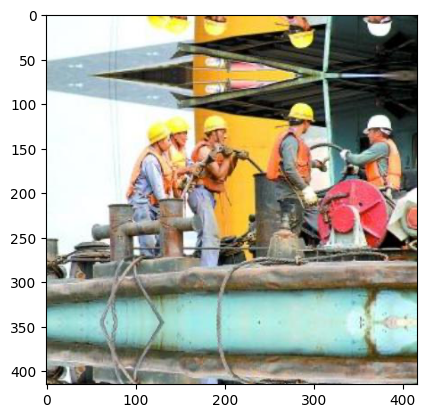

In [54]:
plt.imshow(img_src)
plt.show()

In [55]:
from ultralytics.utils.plotting import Annotator


0: 224x224 10 heads, 56.0ms
Speed: 1.3ms preprocess, 56.0ms inference, 16.2ms postprocess per image at shape (1, 3, 224, 224)


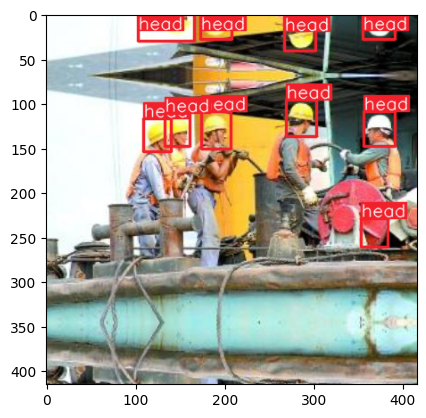

10


In [57]:
num_head = 0
test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

annotator = Annotator(img_src)
boxes = result.boxes

for box in boxes :
    b = box.xyxy[0]
    cls = box.cls

    if 'head' == model.names[int(cls)] :
        num_head += 1

    annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

img_src = annotator.result()

if num_head > 0 :
    cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
    cv2.putText(img_src, 'No Helmet', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
                thickness = 3, lineType = cv2.LINE_AA)

plt.imshow(img_src)
plt.show()

print(num_head)


In [58]:
plt.figure(figsize = (20, 16))

for idx in range(20) :

    num_head = 0
    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    result = model(img_src)[0]

    annotator = Annotator(img_src)
    boxes = result.boxes

    for box in boxes :
        b = box.xyxy[0]
        cls = box.cls

        if 'head' == model.names[int(cls)] :
            num_head += 1

        annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

    img_src = annotator.result()

    plt.subplot(5, 4, (idx + 1))

    if num_head > 0 :
        cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
        cv2.putText(img_src, 'No Helmet', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255),
                    thickness = 3, lineType = cv2.LINE_AA)

    plt.imshow(img_src)
plt.show()


Output hidden; open in https://colab.research.google.com to view.